# Plot PCA Results

## PCA Space Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [14]:
plt.style.use('dark_background')

positions=pd.read_csv('PCA/JD_2mgcol/PCA-normalized-positions.csv') # mode 1: size, mode 2: curvature

# rename columns
column_names=[f'PCA {n}' for n in range(len(positions.columns))]
column_names[0]='name'
positions.columns=column_names

In [16]:
# load contours
aligned_dir='PCA/JulyPDMS_stage21/aligned_contours.pkl'

with open(aligned_dir, 'rb') as file: 
    # Call load method to deserialze 
    contours = pickle.load(file) 
    
print(f'loaded {len(contours)} contours')

loaded 67934 contours


In [17]:
from glob import glob
from natsort import natsorted
from tqdm import tqdm

aligned_dirs=natsorted(glob('F:/my_data/Segmentation/JohnData/180930 star mdck 2mg col wt/contours/*/aligned_contours.pkl'))
contours=[]
for aligned_dir in tqdm(aligned_dirs):
    with open(aligned_dir, 'rb') as file:
        contours.extend(pickle.load(file))

print(f'loaded {len(contours)} contours')

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:13<00:00,  1.29it/s]

loaded 1965753 contours


In [3]:
# get tracking, velocities, mitoses
from spatiotemporal import Stack
from natsort import natsorted
from glob import glob
from tqdm import tqdm

stacks=[Stack(stack_path) for stack_path in tqdm(natsorted(glob('F:/my_data/Segmentation/JohnData/180930 star mdck 2mg col wt/segmented/*/'))[:17])]

100%|██████████| 17/17 [00:25<00:00,  1.51s/it]


In [9]:
pd.concat(stacks[0].mitoses).reset_index()

particle  frame  cell_number           y           x
0         538      2          606  863.760568  520.282930
1         715      3          605  858.757240  534.944086
2         716      3          616  868.500973  499.807462
3          54      3           66  107.196534  940.399967
4         725      4           65   97.743904  955.819302
..        ...    ...          ...         ...         ...
880      2732    108          721  636.726736  815.028280
881      2733    108          757  667.027978  796.280587
882       453    107          826  733.912573  301.194069
883      2735    108          820  726.144333  316.372731
884      2736    108          830  737.689012  285.864423

[885 rows x 5 columns]

In [5]:
tracking=[]
for stack_number, stack in enumerate(tqdm(stacks)):
    t=stack.track_centroids(filter_stubs=False)
    t['stack_number']=stack_number+1
    tracking.append(t)

import pandas as pd
tracking_df=pd.concat(tracking) # 1965753 rows to match up with contours
tracking_df.to_csv('PCA/JD_2mgcol/tracking.csv', index=False)

100%|██████████| 17/17 [02:17<00:00,  8.08s/it]


In [6]:
velocities=[]
for stack in tqdm(stacks):
    v=stack.get_velocities()
    velocities.append(v)

velocities_df=pd.concat(velocities)
velocities_df.to_csv('PCA/JD_2mgcol/velocities.csv', index=False)

100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


In [10]:
mitoses=[]
for stack_number, stack in enumerate(tqdm(stacks)):
    m=pd.concat(stack.get_mitoses()).reset_index()
    m['stack_number']=stack_number+1
    mitoses.append(m)

mitoses_df=pd.concat(mitoses)
mitoses_df.to_csv('PCA/JD_2mgcol/mitoses.csv', index=False)

100%|██████████| 17/17 [03:31<00:00, 12.42s/it]


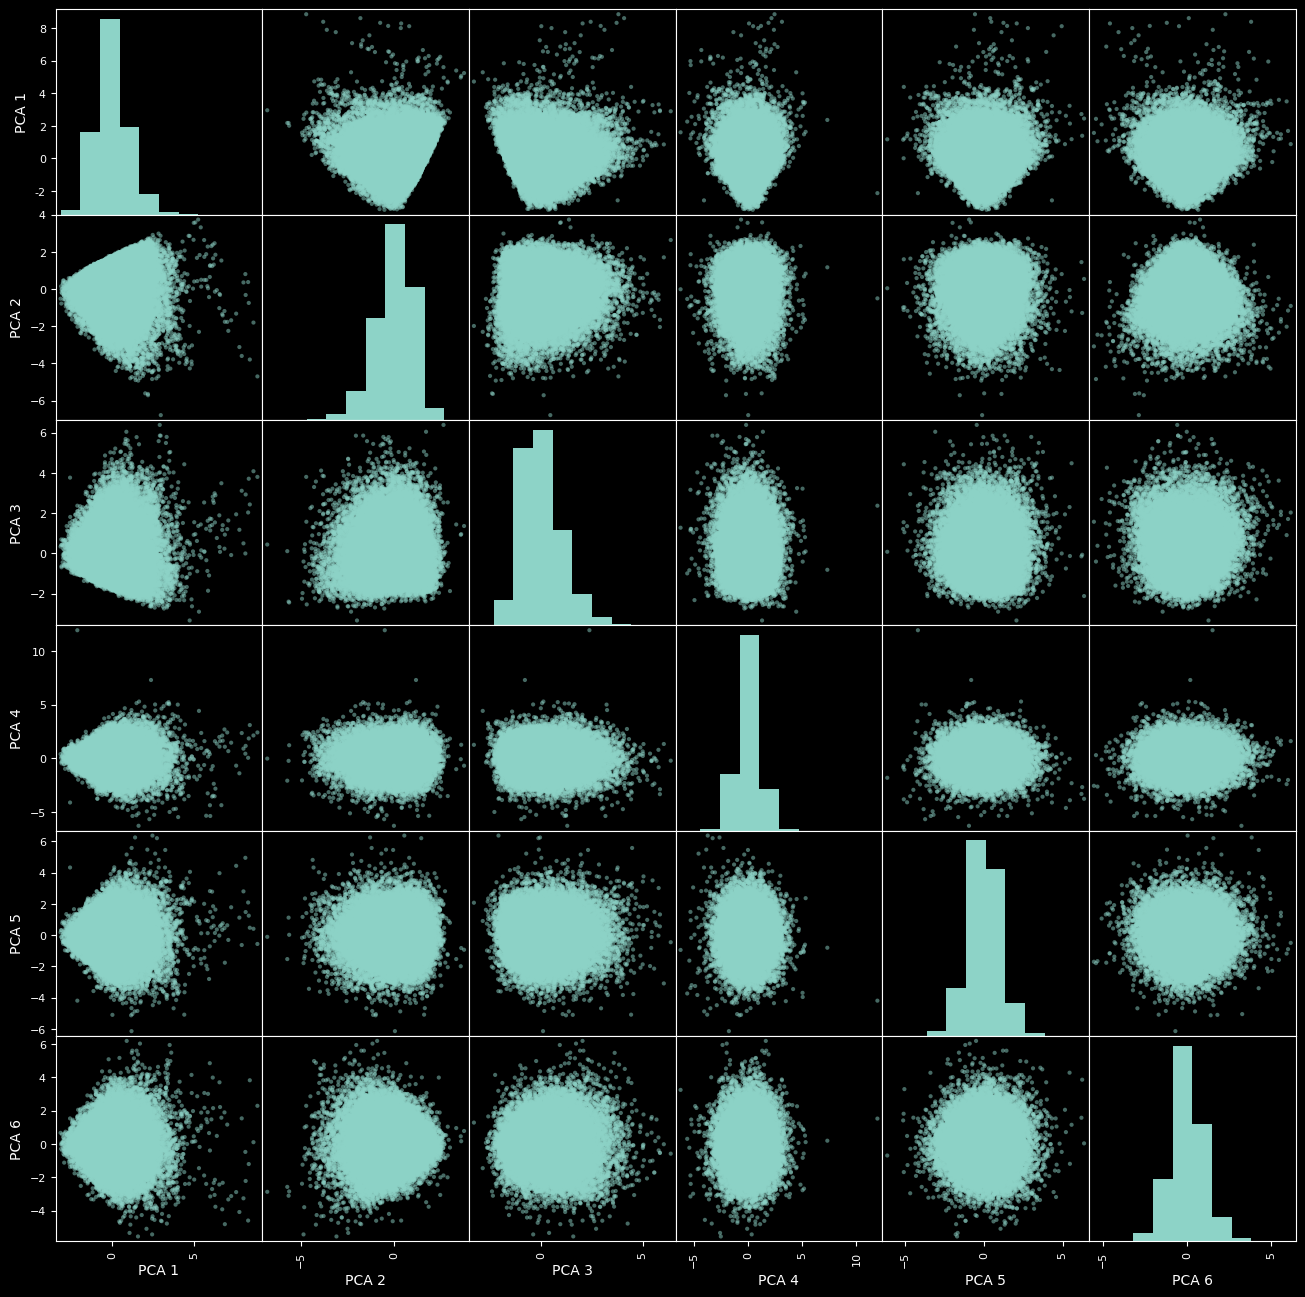

In [16]:
pd.plotting.scatter_matrix(positions,figsize=(16,16)) # plot all modes against each other. Should be uncorreleated bc that's how PCA works but still
plt.show()

Text(0, 0.5, 'PCA 2')

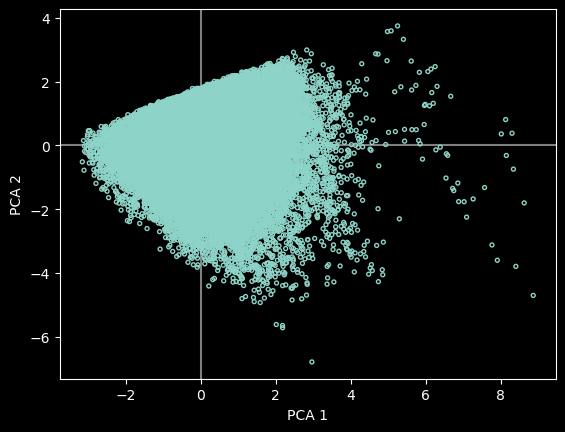

In [17]:
# just plotting the first two mode distributions against each other

ax=plt.subplot()

# set the y-spine
#ax.spines['bottom'].set_position('zero')
#ax.spines['left'].set_position('zero')

# turn off the top spine/ticks
#ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')


ax.axvline(0, color='gray')
ax.axhline(0, color='gray')
ax.scatter(positions['PCA 1'], positions['PCA 2'], s=8, fc='none', ec='C0', zorder=3)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

In [84]:
# scatterplot the actual contours - axis limits invariant

def contour_to_path(contour):
    '''
    Create a matplotlib.path.Path in the shape of the contour.
    This will be used for generating markers for scatter plotting. 
    '''
    from matplotlib.path import Path
    
    bezier=np.array(contour.to_bezier()) # contour class has an option to get nice bezier curves so let's go with that

    # rotate and/or mirror the contours here?
    bezier[:,:,1]=-bezier[:,:,1]
    bezier=np.flip(bezier, axis=2)

    starting_point=bezier[0,0]
    curves=bezier[:,1:,:].reshape(-1, 2)

    # create path.Path from contour for scatter plotting
    vertices=[starting_point, *curves, starting_point]
    codes=[Path.MOVETO, *[Path.CURVE4]*len(curves), Path.CLOSEPOLY]
    return Path(vertices, codes)

def mscatter(x, y, ax=None, m=None, **kw):
    '''
    pyplot bizarrely has no way to scatter points with unique markers efficiently and natively.
    I think changing the paths after scattering is healthier than looping over the plt.scatter function so that's what this does.
    '''
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [15]:
# 2.7 s
plt.figure(figsize=(12,8))
ax=plt.subplot()

markers=[contour_to_path(contour) for contour in contours]
mscatter(positions[f'PCA 5'], positions[f'PCA 4'], ax=ax, m=markers, ec='k', fc='pink', s=300, zorder=3)

ax.axvline(0, color='gray')
ax.axhline(0, color='gray')

ax.set_xlabel('PCA 1 (size)')
ax.set_ylabel('PCA 2 (aspect ratio)')

plt.close()

2.7 s ± 72.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
def draw_contour_positions(x, y, contours, scale=0.01, ax=None, ec='k', fc='pink', linewidth=0.5, alpha=0.75, zorder=3, **kwargs):
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    contour_outlines=[]
    if not ax: ax=plt.gca()
    
    for contour in contours:
        # load contour by name
        points=contour.points.copy()
        points*=scale # scale contours down

        contour_outlines.append(points)
    
    contour_outlines=np.array(contour_outlines)
    contour_outlines[:,:,0]+=np.array(x).reshape(-1,1)
    contour_outlines[:,:,1]+=np.array(y).reshape(-1,1)
    contour_collection=PatchCollection([Polygon(points) for points in contour_outlines], ec=ec, fc=fc, linewidth=linewidth, alpha=alpha, zorder=zorder, **kwargs)

    ax.add_collection(contour_collection)
    ax.autoscale_view()

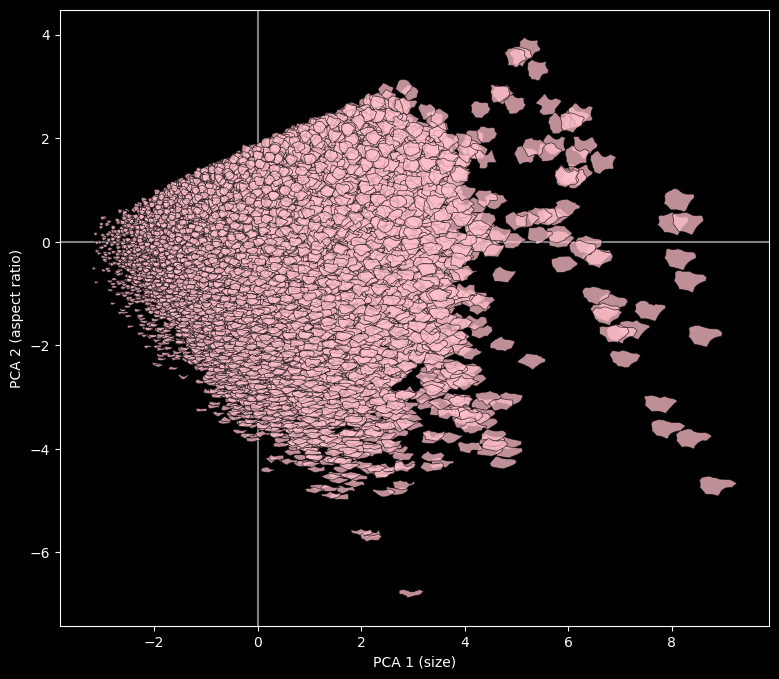

In [20]:
# 250 ms
# draw the actual contours at the PCA positions using a LineCollection - aspect must be equal
plt.figure(figsize=(12,8))
ax=plt.subplot()

draw_contour_positions(positions['PCA 1'], positions['PCA 2'], contours, scale=0.01, ax=ax)

ax.axvline(0, color='gray')
ax.axhline(0, color='gray')

ax.set_aspect('equal')

ax.set_xlabel('PCA 1 (size)')
ax.set_ylabel('PCA 2 (aspect ratio)')

#plt.savefig('PCA/JulyPDMS_stage21/pos_dist.jpg', dpi=300)
plt.show()

## Trajectories through PCA space

In [11]:
mitoses=pd.read_csv('PCA/JD_2mgcol/mitoses.csv')

In [78]:
tracking=pd.read_csv('PCA/JD_2mgcol/velocities.csv', index_col=0).sort_values(['stack_number','frame','cell_number']).reset_index(drop=True)
tracked_PCAs=pd.concat([tracking, positions], axis=1)
tracked_PCAs['contour']=contours

### Predicting velocities using ML

In [7]:
ML_data=tracked_PCAs[['frame','PCA 1', 'PCA 2', 'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 'v', 'theta']].copy() # omitted x, y
ML_data=ML_data.dropna() # should only drop the final frame, which has no velocity data, and final frames of each trajectory, for the same reason
ML_data['log_v']=np.log(ML_data['v'])

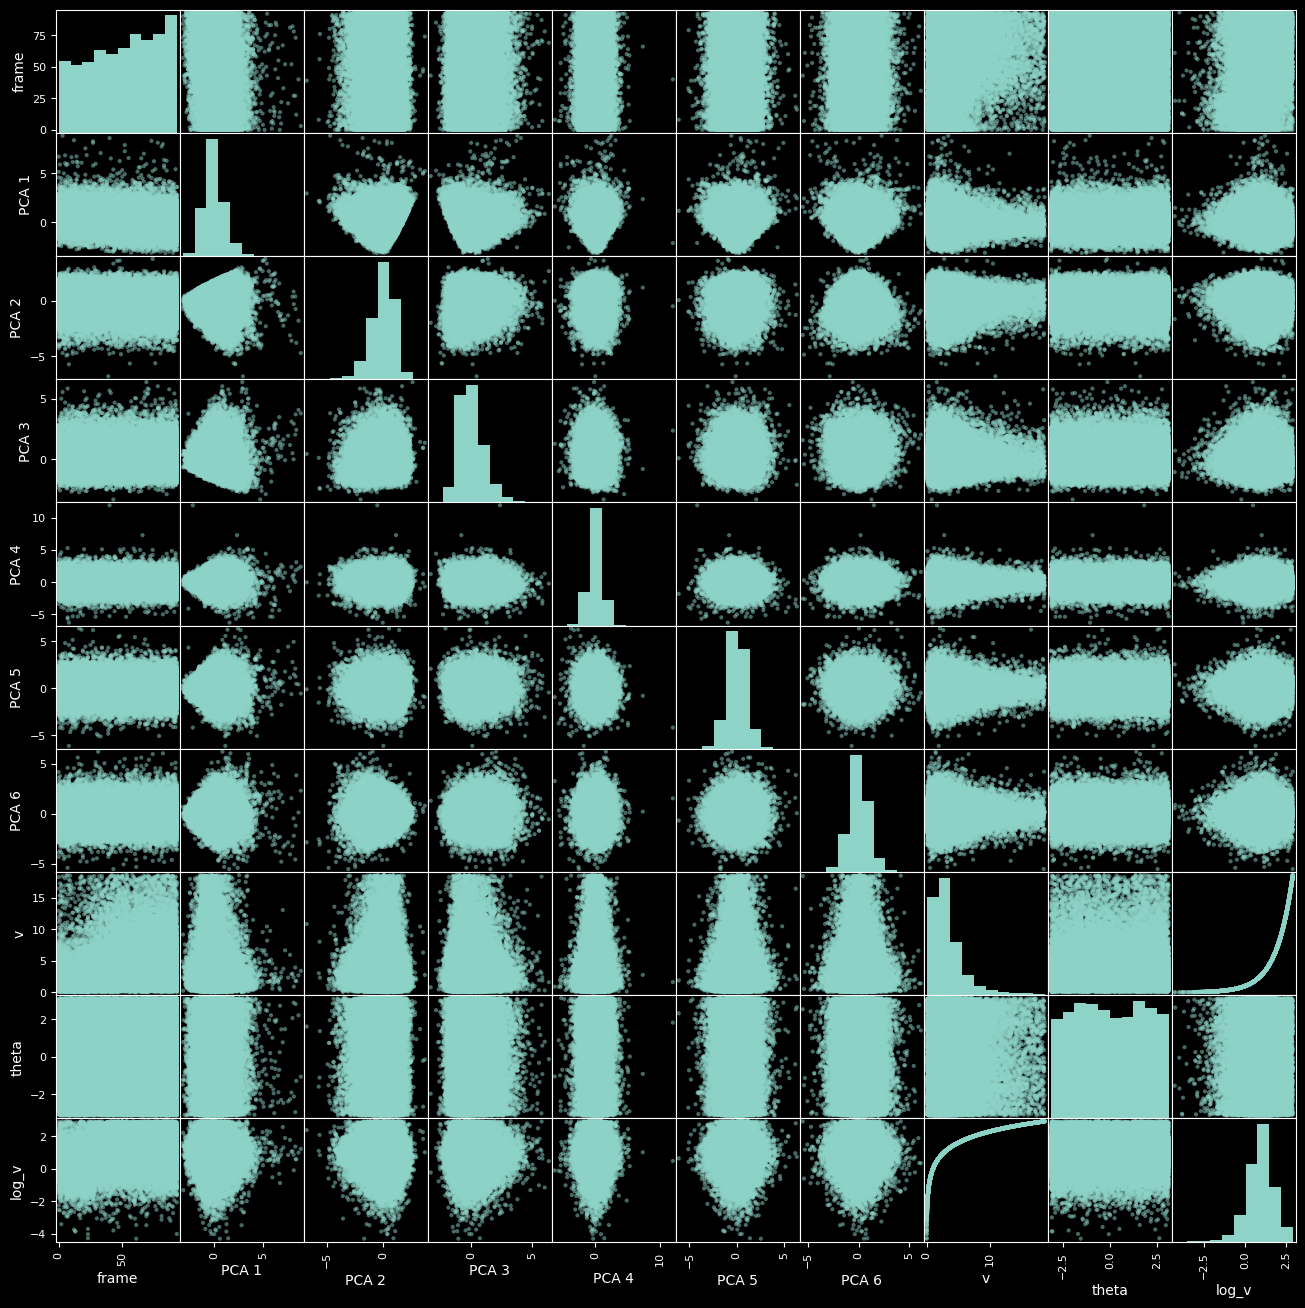

In [254]:
pd.plotting.scatter_matrix(ML_data, figsize=(16,16))
plt.show()

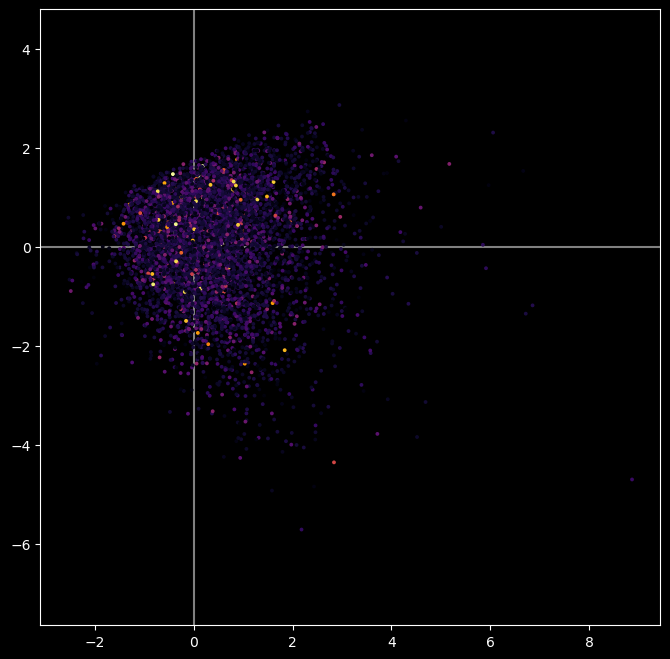

In [198]:
plt.figure(figsize=(8,8))
plt.axis('equal')
data=tracked_PCAs[tracked_PCAs.frame<=10]
plt.scatter(data['PCA 1'], data['PCA 2'], cmap='inferno', c=(data['v']), s=3, alpha=1, zorder=3)
plt.axvline(0, color='gray')
plt.axhline(0, color='gray')

frame     PCA 1     PCA 2     PCA 3     PCA 4     PCA 5     PCA 6  \
frame  1.000000 -0.216594 -0.051397  0.009488  0.011067  0.004741  0.009635   
PCA 1 -0.216594  1.000000 -0.000091 -0.000576  0.001237 -0.000742 -0.000683   
PCA 2 -0.051397 -0.000091  1.000000 -0.000104  0.000498 -0.000887 -0.000279   
PCA 3  0.009488 -0.000576 -0.000104  1.000000 -0.000212 -0.000090 -0.001359   
PCA 4  0.011067  0.001237  0.000498 -0.000212  1.000000  0.001442  0.001174   
PCA 5  0.004741 -0.000742 -0.000887 -0.000090  0.001442  1.000000  0.000681   
PCA 6  0.009635 -0.000683 -0.000279 -0.001359  0.001174  0.000681  1.000000   
v      0.206575 -0.072149 -0.018735  0.007500  0.007981  0.006804  0.002546   
theta -0.003188  0.007894 -0.001172 -0.009253 -0.003303  0.001384  0.003525   
log_v  0.237242 -0.079872 -0.023819  0.006170  0.008886  0.002842  0.003420   

              v     theta     log_v  
frame  0.206575 -0.003188  0.237242  
PCA 1 -0.072149  0.007894 -0.079872  
PCA 2 -0.018735 -0.001172 -0.023819  
PCA 3  0.007500 -0.009253  0.006170  
PCA 4  0.007981 -0.003303  0.008886  
PCA 5  0.006804  0.001384  0.002842  
PCA 6  0.002546  0.003525  0.003420  
v      1.000000  0.020761  0.858980  
theta  0.020761  1.000000  0.021383  
log_v  0.858980  0.021383  1.000000

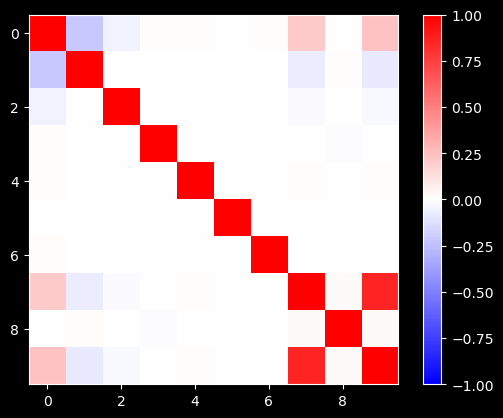

In [255]:
# correlation matrix: a naive check to see if any parameters linearly scale with each other
from matplotlib import colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)
    
corr_matrix=ML_data.corr()
plt.imshow(corr_matrix, cmap='bwr', norm=MidpointNormalize(vmin=-1, vcenter=0, vmax=1))
plt.colorbar()

corr_matrix

In [295]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(ML_data, test_size=0.5, stratify=ML_data['frame'], random_state=42)

X_train=train_set.drop(['v','log_v', 'theta'], axis=1)
y_train=train_set[['log_v','theta']].copy()

X_test=test_set.drop(['v','log_v', 'theta'], axis=1)
y_test=test_set[['log_v','theta']].copy()

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

min_max_scaler=MinMaxScaler(feature_range=(-1,1))
preprocessing=ColumnTransformer([('frame_norm', min_max_scaler, ['frame'])], remainder='passthrough') # PCA positions are already normalized. Just need to rescale frame number.

#X_scaled=preprocessing.fit_transform(X)

#### Random Forest Regression

In [289]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, X, y['log_v'], scoring="neg_root_mean_squared_error", cv=10)

In [290]:
pd.Series(forest_rmses).describe()

count    10.000000
mean      0.777363
std       0.006095
min       0.766903
25%       0.775216
50%       0.775771
75%       0.782406
max       0.786433
dtype: float64

In [297]:
forest_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('frame_norm',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['frame'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
from sklearn.metrics import mean_squared_error
test_predictions=forest_reg.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse) # 1.3 on a mean of 1. not good.

#### Regression MLP

In [164]:
ML_data=tracked_PCAs[['v', 'theta']].copy() # omitted x, y 'frame', 'PCA 1', 'PCA 2', 'PCA 3', 'PCA 4', 'PCA 5', 'PCA 6', 

align_angle=[]
for contour in tracked_PCAs['contour']:
    transformation=contour.to_world_transform
    align_angle.append(np.arctan2(transformation[0,1], transformation[0,0]))

ML_data['align_angle']=np.array(align_angle)%np.pi
ML_data['theta']=ML_data['theta']%np.pi

ML_data=ML_data.dropna() # should only drop the final frame, which has no velocity data, and final frames of each trajectory, for the same reason
ML_data['log_v']=np.log(ML_data['v'])

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()

scaled_data=std_scaler.fit_transform(ML_data) # standardize data
scaled_data=pd.DataFrame(scaled_data, columns=ML_data.columns, index=ML_data.index)
scaled_data[['align_angle', 'theta']]=scaled_data[['align_angle', 'theta']].abs()

X=scaled_data.drop(['v','log_v', 'theta'], axis=1)
y=scaled_data[['log_v','theta']].copy()
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)#, stratify=ML_data['frame'], random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [76]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [202]:
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

model = tf.keras.Sequential([#norm_layer,
    #tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1) # use_bias=False
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3) # optimizer: SGD, Adam
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train['theta'], epochs=5, validation_data=(X_valid, y_valid['theta']))
mse_test, rmse_test = model.evaluate(X_test, y_test['theta'])
print(rmse_test)

Epoch 1/5
1225/1225 [==============================] - 5s 4ms/step - loss: 0.2663 - root_mean_squared_error: 0.5160 - val_loss: 0.2566 - val_root_mean_squared_error: 0.5065
Epoch 2/5
1225/1225 [==============================] - 4s 3ms/step - loss: 0.2599 - root_mean_squared_error: 0.5098 - val_loss: 0.2625 - val_root_mean_squared_error: 0.5124
Epoch 3/5
1225/1225 [==============================] - 4s 4ms/step - loss: 0.2592 - root_mean_squared_error: 0.5091 - val_loss: 0.2597 - val_root_mean_squared_error: 0.5096
Epoch 4/5
1225/1225 [==============================] - 4s 4ms/step - loss: 0.2594 - root_mean_squared_error: 0.5093 - val_loss: 0.2537 - val_root_mean_squared_error: 0.5037
Epoch 5/5
409/409 [==============================] - 1s 2ms/step - loss: 0.2604 - root_mean_squared_error: 0.5103
0.5103132724761963


In [208]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression() #fit_intercept=False
lin_reg.fit(X_test[['align_angle']], y_test['theta'])

LinearRegression()

(-1.8282464274023245,
 1.7220646139194098,
 -1.7939454540730997,
 1.7342325331336625)

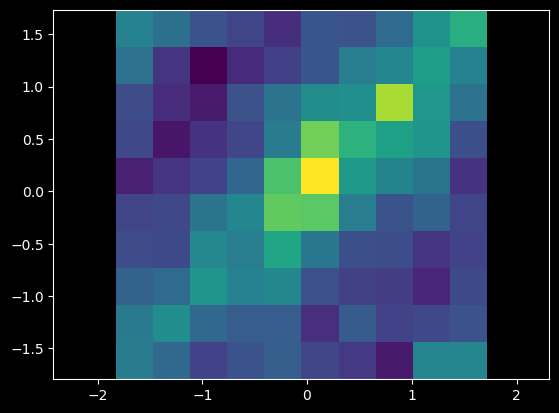

In [186]:
plt.hist2d(X_test['align_angle'], y_test['theta'])
plt.axis('equal')

In [203]:
y_pred = model.predict(X_test)

409/409 [==============================] - 1s 1ms/step


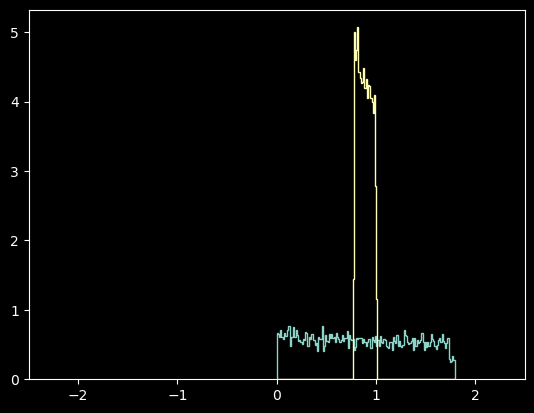

In [204]:
n, bins=plt.hist(y_test['theta'], bins=150, density=True, histtype='step')[:2]
plt.hist(y_pred, bins=bins, density=True, histtype='step')
plt.xlim(-2.5,2.5)
plt.show()

(-0.15706351104949046,
 3.298635357243244,
 -0.1570563568341294,
 3.2986323746528727)

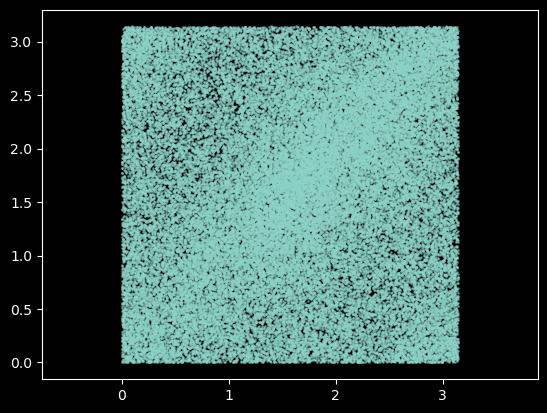

In [147]:
plt.scatter(ML_data['align_angle']%np.pi, ML_data['theta']%np.pi, s=1, alpha=0.5)
plt.axis('equal')
#plt.colorbar()

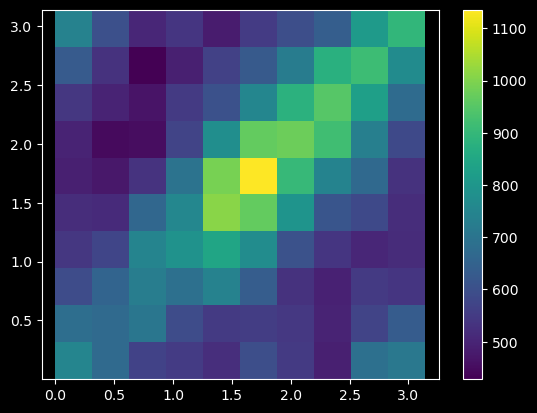

In [148]:
plt.hist2d(ML_data['align_angle']%np.pi, ML_data['theta']%np.pi)
plt.axis('equal')
plt.colorbar()

Text(0, 0.5, 'prediction')

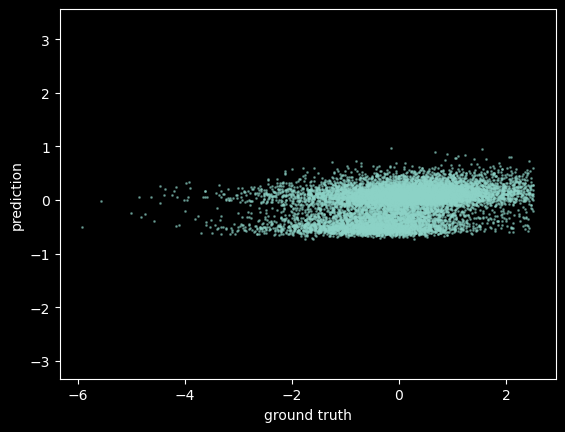

In [97]:
plt.scatter(y_test['log_v'], y_pred, s=1, alpha=0.5)
plt.axis('equal')
plt.xlabel('ground truth')
plt.ylabel('prediction')

### Cells over time

In [86]:
def cell_PCA_trajectory(x, y, contours, scale=0.003, ax=None, alpha=1, colors=None, **kwargs):
    if not ax: ax=plt.gca()
    multicolored_linecollection(x, y, colors=colors, ax=ax)
    draw_contour_positions(x, y, contours, scale=scale, ax=ax, alpha=alpha, fc=colors)
    
def multicolored_linecollection(x, y, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    if not ax: ax=plt.gca()
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, **kwargs)
    line = ax.add_collection(lc)

In [79]:
tracked_PCAs['unique_particle']=tracked_PCAs.groupby(['stack_number', 'particle']).ngroup()
mapping=tracked_PCAs[['unique_particle', 'stack_number', 'particle']].drop_duplicates(keep='first').set_index(['stack_number', 'particle'])

long_tracks=tracked_PCAs[tracked_PCAs.groupby('unique_particle').transform('size')>20].copy()

In [80]:
mitoses['unique_particle']=mapping.reindex(pd.MultiIndex.from_frame(mitoses[['stack_number','particle']])).reset_index(drop=True)
mother_cells=mitoses.iloc[::3]['unique_particle']

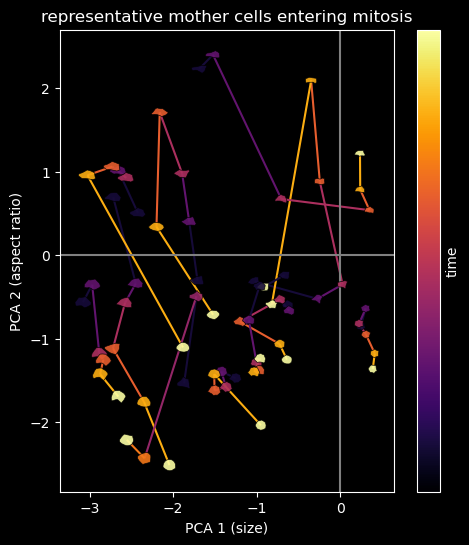

In [167]:
import matplotlib as mpl
fig, ax=plt.subplots(1,1,figsize=(6,6))

for mother_cell_ID in mother_cells[0:12]:
    demo_cell=tracked_PCAs[tracked_PCAs.unique_particle==mother_cell_ID].iloc[-6:]
    cell_PCA_trajectory(demo_cell['PCA 1'], demo_cell['PCA 2'], demo_cell['contour'], ax=ax, colors=plt.cm.inferno(np.linspace(0.1,1,len(demo_cell))), scale=0.008, alpha=0.9)
ax.axvline(0, color='gray')
ax.axhline(0, color='gray')

ax.set_aspect('equal')

ax.set_xlabel('PCA 1 (size)')
ax.set_ylabel('PCA 2 (aspect ratio)')
ax.set_title('representative mother cells entering mitosis')

sm = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.1, vmax=1), cmap='inferno') 
sm.set_array([]) 
plt.colorbar(sm, ax=ax, label='time', ticks=[])

plt.savefig('plots/characteristic_mitosis_PCA.jpg', dpi=300)
plt.show()

In [223]:
all_PCA_values=[]
for mother_cell_ID in tqdm(mother_cells):
    timespan=12
    demo_cell=tracked_PCAs[tracked_PCAs.unique_particle==mother_cell_ID].iloc[-timespan:]
    PCA_values=demo_cell[[f'PCA {n}' for n in range(1,8)]].to_numpy()
    if len(PCA_values)<timespan:
        padding=np.empty((timespan-len(PCA_values), 7))
        padding[:]=np.nan
        PCA_values=np.concatenate([padding, PCA_values])
    all_PCA_values.append(np.subtract(PCA_values, PCA_values[-1]))

100%|██████████| 6537/6537 [00:12<00:00, 517.17it/s]


In [224]:
all_PCA_values=np.array(all_PCA_values)
mean_mitosis_PCA=np.nanmean(all_PCA_values, axis=0)
std_mitosis_PCA=np.nanstd(all_PCA_values, axis=0)

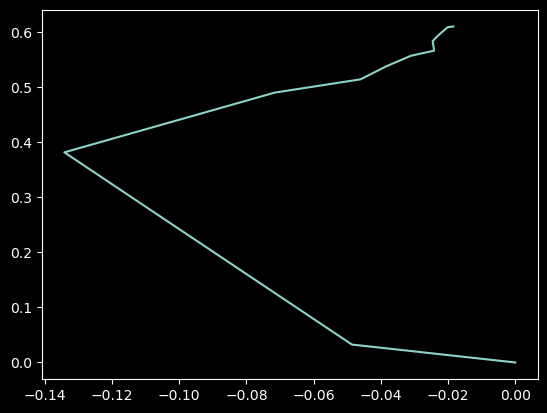

In [225]:
plt.plot(mean_mitosis_PCA[:,0], mean_mitosis_PCA[:,1])

[-0.73707166 -0.27647462  0.01635022 -0.01033394  0.02746463 -0.00382018
 -0.03496479]
[-0.75019495 -0.26920249 -0.00737432  0.01267631  0.02434225 -0.02375568
 -0.01660579]
[-7.62391204e-01 -2.72980507e-01  1.79324038e-02  8.39260253e-05
  3.57205517e-02 -3.10984017e-02  2.16665729e-03]
[-0.76815443 -0.26857791  0.00836626  0.00327218  0.03944713 -0.01903252
 -0.01240295]
[-0.78058637 -0.26571233  0.01256983  0.00509397  0.01578259 -0.03118414
 -0.00643582]
[-0.7961966  -0.25938729  0.01219422  0.0091642   0.02551558 -0.04322415
 -0.02666189]
[-0.81317523 -0.25817422  0.009218    0.01639222  0.02162184 -0.02313962
 -0.02524099]
[-0.83975962 -0.2490049   0.00686622  0.01097039  0.01237463 -0.02995044
 -0.03165956]
[-0.88365494 -0.24285928  0.01007741 -0.00405229  0.01711087 -0.03985493
 -0.02015201]
[-0.96434366 -0.31723515 -0.07042761 -0.09993491  0.06067264 -0.03456311
  0.00326358]
[-0.89176986 -0.60605883 -0.28220472 -0.32771764  0.16521359 -0.14127959
  0.05353712]
[-0.86445228 -0

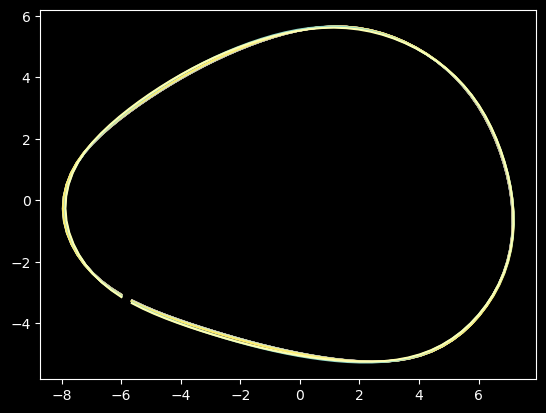

In [215]:
from celltool.contour import contour_class
pca_contour=contour_class.from_file('PCA/JD_2mgcol/PCA model.contour')

for pos in mean_mitosis_PCA:
    print(pos)
    contour=pca_contour.as_position(pos, normalized=False)
    plt.plot(*contour.points.T)

In [164]:
8-len(demo_cell)

2

In [153]:
PCA_values.shape
np.pad(PCA_values, 1, constant_values=np.nan)

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [        nan, -0.96688974, -0.36984066,  0.00152949, -0.56551209,
         0.79636664,  0.7482366 ,         nan],
       [        nan, -1.09321512, -0.776007  ,  0.01231188, -0.65064193,
         0.74919143,  0.59244946,         nan],
       [        nan, -1.00167237, -1.28448357,  0.70210682, -0.94645265,
         0.57055517, -0.45583234,         nan],
       [        nan, -0.97052924, -1.37818555,  0.39698711, -1.38992804,
         0.57379298,  0.62702588,         nan],
       [        nan, -1.03149775, -1.3963407 ,  0.75149148, -1.12597402,
         0.14182631,  0.04535157,         nan],
       [        nan, -0.95662288, -1.23454364,  0.81979136, -1.041418  ,
         0.18288995,  0.19333539,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan]])

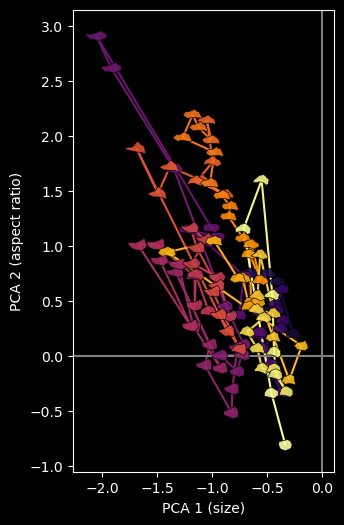

In [101]:
plt.figure(figsize=(6,6))
ax=plt.subplot()

demo_cell=long_tracks[long_tracks.unique_particle==500]

cell_PCA_trajectory(demo_cell['PCA 1'], demo_cell['PCA 2'], demo_cell['contour'], colors=plt.cm.inferno(np.linspace(0.1,1,len(demo_cell))), scale=0.008, alpha=0.9)
ax.axvline(0, color='gray')
ax.axhline(0, color='gray')

ax.set_aspect('equal')

ax.set_xlabel('PCA 1 (size)')
ax.set_ylabel('PCA 2 (aspect ratio)')


plt.show()

In [234]:
np.where(pd.concat(mitoses).groupby('particle').size()>=2)
pd.concat(mitoses).groupby('particle').size().index[162]
pd.concat(mitoses)[pd.concat(mitoses).particle==574] # this cell is birthed and also dies within the timespan

particle  frame  cell_number            y           x
2         574      3          511  1572.472482  641.175429
522       574     92          898  1634.313624  645.543593

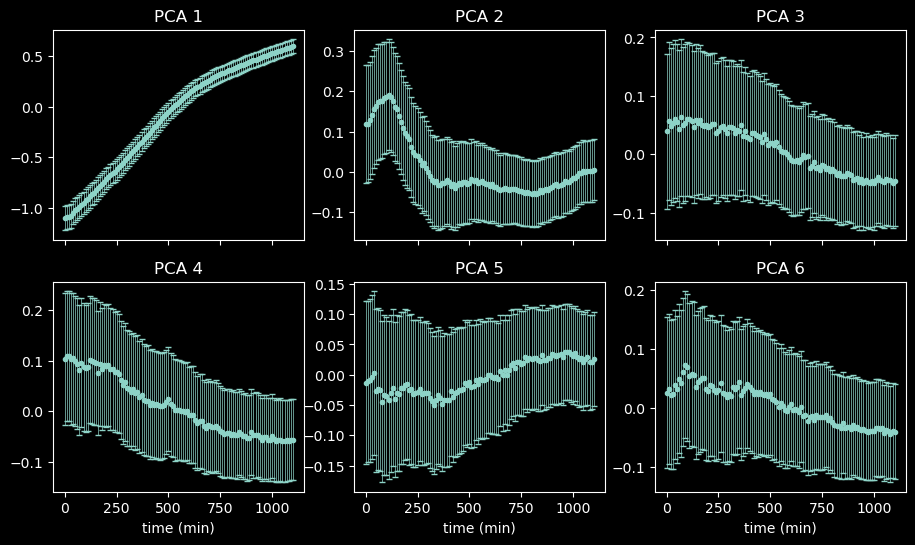

In [91]:
PCA_vs_time=tracked_PCAs.groupby('frame')[[f'PCA {n}' for n in range(1,7)]].agg(['mean','std'])

fig, axes = plt.subplots(2,3, figsize=(11,6), sharex=True)

for component, ax in zip([f'PCA {n}' for n in range(1,7)], axes.flatten()):
    ax.errorbar(np.arange(0,len(PCA_vs_time))*10, PCA_vs_time[component, 'mean'], yerr=PCA_vs_time[component, 'std']/10, fmt='.', linewidth=0.5, capsize=2)

    ax.set_title(component)

for ax in axes[1]:
    ax.set_xlabel('time (min)')

plt.savefig('plots/PDP-PCA_vs_time.jpg', dpi=300)

In [235]:
for n, m in enumerate(mitoses):
    if np.sum(m.particle==574)>0:
        print(n, m)

0    particle  frame  cell_number            y           x
0       497      2          517  1555.763029  626.249377
1       573      3          502  1537.188066  608.109321
2       574      3          511  1572.472482  641.175429
174      particle  frame  cell_number            y           x
522       574     92          898  1634.313624  645.543593
523      2602     93          893  1614.527176  663.719621
524      2603     93          912  1642.859393  627.333240


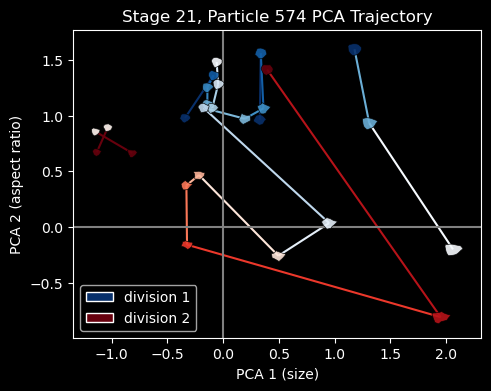

In [318]:
plt.figure(figsize=(6,4))
ax=plt.subplot()

m=mitoses[0]

mother_cell=tracked_PCAs[tracked_PCAs.particle==m['particle'].iloc[0]].iloc[-8:]
daughter_cells=[tracked_PCAs[tracked_PCAs.particle==daughter_particle].iloc[:7] for daughter_particle in m['particle'].iloc[1:]]

cell_PCA_trajectory(mother_cell['PCA 1'],mother_cell['PCA 2'],mother_cell['contour'], colors=plt.cm.Blues(np.linspace(0,1,len(mother_cell))), scale=0.005, alpha=0.9)
for cmap, daughter_cell in zip([plt.cm.Blues_r, plt.cm.plasma], daughter_cells):
    cell_PCA_trajectory(daughter_cell['PCA 1'],daughter_cell['PCA 2'],daughter_cell['contour'], colors=cmap(np.linspace(0,1,len(daughter_cell))), scale=0.005, alpha=0.9)
    break

m=mitoses[174]

mother_cell=tracked_PCAs[tracked_PCAs.particle==m['particle'].iloc[0]].iloc[1::8]
daughter_cells=[tracked_PCAs[tracked_PCAs.particle==daughter_particle].iloc[:7] for daughter_particle in m['particle'].iloc[1:]]

cell_PCA_trajectory(mother_cell['PCA 1'],mother_cell['PCA 2'],mother_cell['contour'],
                    colors=np.concatenate([plt.cm.Blues_r(np.linspace(0,1,len(mother_cell)))[::2],plt.cm.Reds(np.linspace(0,1,len(mother_cell)))[1::2]]),
                    scale=0.005, alpha=0.9)

for cmap, daughter_cell in zip([plt.cm.Reds_r, plt.cm.Reds_r], daughter_cells):
    cell_PCA_trajectory(daughter_cell['PCA 1'],daughter_cell['PCA 2'],daughter_cell['contour'], colors=cmap(np.linspace(0,1,len(daughter_cell))), scale=0.005, alpha=0.9)

ax.axvline(0, color='gray')
ax.axhline(0, color='gray')

ax.set_aspect('equal')

ax.set_xlabel('PCA 1 (size)')
ax.set_ylabel('PCA 2 (aspect ratio)')

plt.title('Stage 21, Particle 574 PCA Trajectory')

handles=[Patch(facecolor=plt.cm.Blues_r(0), edgecolor='white', label='division 1'),
         Patch(facecolor=plt.cm.Reds_r(0), edgecolor='white', label='division 2')]

plt.legend(handles=handles, loc='lower left')

plt.savefig('PCA/JulyPDMS_stage21/mitosis_lineage.jpg', dpi=300)
plt.show()

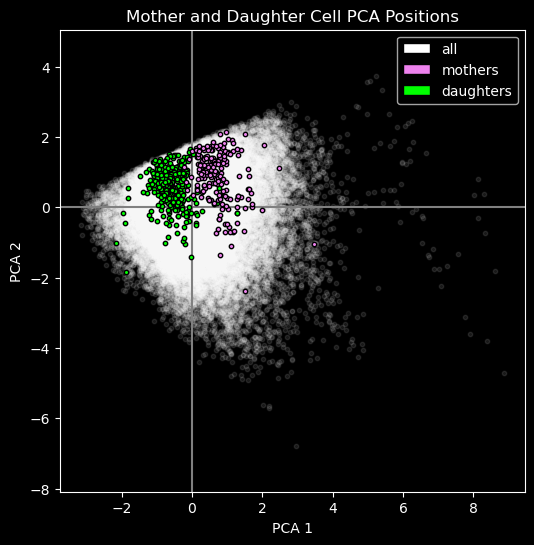

In [307]:
from matplotlib.patches import Patch

attr_1='PCA 1'
attr_2='PCA 2'

mothers=[]
daughters=[]
for m in mitoses:
    mothers.append(tracked_PCAs[tracked_PCAs.particle==m['particle'].iloc[0]].iloc[-1])
    for daughter_particle in m['particle'].iloc[1:]:
        daughters.append(tracked_PCAs[tracked_PCAs.particle==daughter_particle].iloc[0])
        
mothers=pd.concat(mothers, axis=1).T
daughters=pd.concat(daughters, axis=1).T

plt.figure(figsize=(6,6))
plt.axis('equal')

plt.axvline(0, color='gray')
plt.axhline(0, color='gray')

plt.scatter(tracked_PCAs[attr_1], tracked_PCAs[attr_2], s=10, alpha=0.1, fc='white')

plt.scatter(daughters[attr_1], daughters[attr_2], s=10, ec='k', fc='lime', zorder=3)
plt.scatter(mothers[attr_1], mothers[attr_2], s=10, ec='k', fc='violet', zorder=4)

handles=[Patch(facecolor='white', edgecolor='k', label='all'),
         Patch(facecolor='violet', edgecolor='k', label='mothers'),
         Patch(facecolor='lime', edgecolor='k', label='daughters')]

plt.legend(handles=handles)

plt.xlabel(attr_1)
plt.ylabel(attr_2)

plt.title('Mother and Daughter Cell PCA Positions')
plt.savefig('PCA/JulyPDMS_stage21/PCA_space_mitoses.jpg',dpi=300)

## Shape RNN

In [6]:
import tensorflow as tf

frame_cutoff=20
long_track_IDs=np.where(tracked_PCAs.groupby('particle').size()>frame_cutoff)[0]
long_tracks=tracked_PCAs.set_index(['particle','frame']).loc[long_track_IDs[:200]].reset_index()

print(f'found {len(long_track_IDs)} tracks over {frame_cutoff} frames long')

found 1039 tracks over 20 frames long


In [7]:
align_angle=[]
for contour in tracked_PCAs['contour']:
    transformation=contour.to_world_transform
    align_angle.append(np.arctan2(transformation[0,1], transformation[0,0]))

tracked_PCAs['align_angle']=np.array(align_angle)/np.pi # normalized orientation

In [8]:
GROUPBY = 'particle'
long_tracks=long_tracks[['particle','frame']+[f'PCA {n}' for n in np.arange(1,7)]]

# split by timepoints
train_series = long_tracks.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = long_tracks.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = long_tracks.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

# TODO: split by cell ID instead of timepoints
train_series.shape, val_series.shape, test_series.shape

((9977, 8), (2874, 8), (1543, 8))

In [8]:
n=len(long_track_IDs)
shuffled_IDs=np.random.permutation(long_track_IDs[:n])
train_series=tracked_PCAs.set_index(['particle','frame']).loc[shuffled_IDs[:int(n*0.7)]].reset_index()
val_series=tracked_PCAs.set_index(['particle','frame']).loc[shuffled_IDs[int(n*0.7):int(n*0.9)]].reset_index()
test_series=tracked_PCAs.set_index(['particle','frame']).loc[shuffled_IDs[int(n*0.9):]].reset_index()

train_series.shape, val_series.shape, test_series.shape

((41893, 18), (11309, 18), (6083, 18))

In [9]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], DATE=None, GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    self.GROUPBY = GROUPBY 
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns
    self.DATE=DATE

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}', 
        f'GROUPBY column(s): {self.GROUPBY}' 
        ])

def preprocess_dataset(self:MultiSeriesWindowsGenerator, data:pd.DataFrame):
    if np.vstack(data.index).shape[1] != 1:
      data = data.reset_index() 
    by = self.GROUPBY + [self.DATE] 
    labels = self.label_columns + self.regressor_columns + self.static_columns
    data = data.set_index(by).unstack(-1)
    data = tf.stack([data[label] for label in labels], axis=-1)
    
    if data.ndim != 3:
        data = data[None, None, tf.newaxis]
    #except Exception as e:
    #  print('Error while processing dataset', e)
    return data 

def update_datasets(self:MultiSeriesWindowsGenerator, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm:
      train_mean = tf.reduce_mean(self.train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(self.train_df, axis=1, keepdims=True)

      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      self.train_mean = train_mean 
      self.train_std = train_std 
      self.norm = norm 

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}

MultiSeriesWindowsGenerator.preprocess_dataset = preprocess_dataset 
MultiSeriesWindowsGenerator.update_datasets = update_datasets

def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None: 
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] 
          for name in self.label_columns], axis=-1)
          
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels 
     
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32) 
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=True, 
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window) 
    return ds 

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0) 
    labels = tf.concat([window[1] for window in windows], 0) 
    return (features, labels)
    
def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:    
    from tqdm import tqdm
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(tf.boolean_mask(t, tf.reduce_all(~tf.math.is_nan(t), axis=-1))) # drop nan rows
                    for t in tqdm(data))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch() 
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size) 
    ds = ds.prefetch(1)
    return ds 

MultiSeriesWindowsGenerator.make_cohort = make_cohort
MultiSeriesWindowsGenerator.make_dataset = make_dataset
MultiSeriesWindowsGenerator.split_window = split_window

@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property 
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property 
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None) 
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None: 
        result = next(iter(self.train)) 
        self._example = result 
    return result 

MultiSeriesWindowsGenerator.train = train 
MultiSeriesWindowsGenerator.test = test 
MultiSeriesWindowsGenerator.val = val 
MultiSeriesWindowsGenerator.example = example


In [10]:
w1 = MultiSeriesWindowsGenerator(input_width=15, label_width=1, shift=1, batch_size=24, label_columns=[f'PCA {n}' for n in np.arange(1,7)]+['align_angle'], DATE='frame', GROUPBY=['particle'])
w1.update_datasets(train_series, val_series, test_series, norm=False)

In [15]:
train_set=w1.train
valid_set=w1.val
test_set=w1.test

100%|██████████| 104/104 [00:12<00:00,  8.31it/s]


In [26]:
for example_inputs, example_labels in train_set.take(1): # takes weirdly long
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (24, 9, 7)
Labels shape (batch, time, features): (24, 1, 7)


In [16]:
from pathlib import Path

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),#, input_shape=[None, 7]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(7)
])


early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

checkpoint_path=Path('ML_checkpoints/shape_RNN/weights.{epoch:04d}-{val_loss:.4f}.hdf5')
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_mae', verbose=0, save_best_only=True, save_weights_only=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          928       
                                                                 
 gru_3 (GRU)                 (None, None, 32)          6336      
                                                                 
 gru_4 (GRU)                 (None, None, 32)          6336      
                                                                 
 gru_5 (GRU)                 (None, None, 32)          6336      
                                                                 
 dense_1 (Dense)             (None, None, 7)           231       
                                                                 
Total params: 20,167
Trainable params: 20,167
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(train_set, validation_data=valid_set, epochs=1000,
                    callbacks=[checkpoint_cb])

valid_loss, valid_mae = model.evaluate(valid_set)

Epoch 1/1000
688/688 [==============================] - 126s 105ms/step - loss: 0.3272 - mae: 0.6725 - val_loss: 0.3208 - val_mae: 0.6667
Epoch 2/1000
688/688 [==============================] - 75s 46ms/step - loss: 0.3050 - mae: 0.6404 - val_loss: 0.3035 - val_mae: 0.6438
Epoch 3/1000
688/688 [==============================] - 75s 45ms/step - loss: 0.2947 - mae: 0.6258 - val_loss: 0.2973 - val_mae: 0.6343
Epoch 4/1000
688/688 [==============================] - 67s 43ms/step - loss: 0.2923 - mae: 0.6213 - val_loss: 0.2935 - val_mae: 0.6283
Epoch 5/1000
688/688 [==============================] - 67s 43ms/step - loss: 0.2905 - mae: 0.6187 - val_loss: 0.2946 - val_mae: 0.6293
Epoch 6/1000
688/688 [==============================] - 67s 43ms/step - loss: 0.2894 - mae: 0.6165 - val_loss: 0.2933 - val_mae: 0.6276
Epoch 7/1000
688/688 [==============================] - 67s 43ms/step - loss: 0.2887 - mae: 0.6154 - val_loss: 0.2906 - val_mae: 0.6234
Epoch 8/1000
688/688 [========================

## Cluster Analysis?

## PCA Transform other contours